In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lbg_forecast.sfh as sfh
import torchvision
import gpytorch
import torch
from duste.DustAttnCalc import DustAttnCalc
import duste.DustAttnCalc as dd
import lbg_forecast.dust_priors as dp
import scipy as sc

import lbg_forecast.priors_gp_dust as gpdp

In [2]:
dust_prior = gpdp.DustPrior()
n, tau, tau1, ne, taue, tau1e, sfr = dust_prior.n, dust_prior.tau, dust_prior.tau1, dust_prior.ne, dust_prior.taue, dust_prior.tau1e, dust_prior.sfr
recent_sfrs, dust2, dust_index, dust1 = dust_prior.recent_sfrs, dust_prior.dust2, dust_prior.dust_index, dust_prior.dust1

Loading Models
Loading Complete


<ErrorbarContainer object of 3 artists>

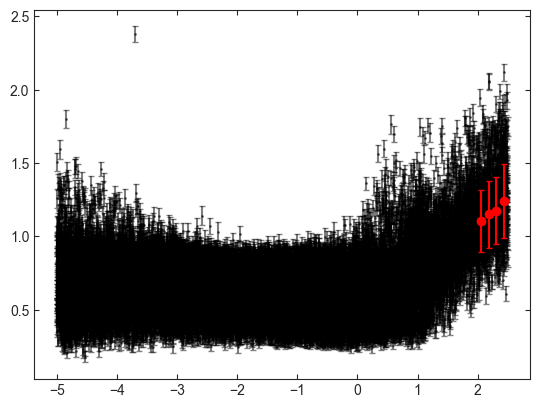

In [29]:
plt.errorbar(sfr, tau, taue, fmt='ko', ms=1, capsize=2, alpha=0.5, zorder=-1)
bin_centers_de, bin_means_de, bin_std_de = gpdp.process_samples(sfr, tau, 2.0, 2.5, 5)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)

<ErrorbarContainer object of 3 artists>

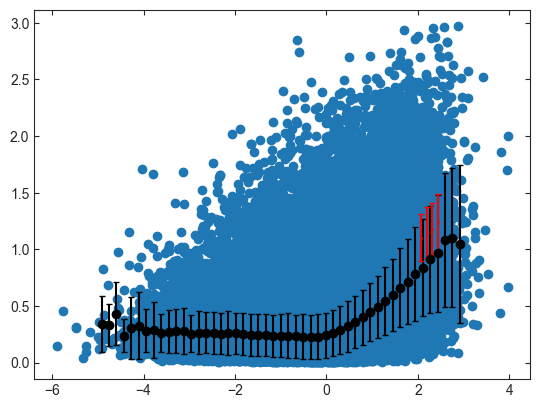

In [30]:
plt.scatter(recent_sfrs, dust2)
bin_centers, bin_means, bin_std = gpdp.process_samples(recent_sfrs, dust2, -5, 3, 50)
plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)

In [31]:
train_sfrs, train_dust2, train_dust2_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)
#avg_err = (bin_std + bin_std_de)/2
#x, y, yerr = gpdp.process_samples(train_sfrs, train_dust2, -4, 2.5, 25)
#plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2, alpha=0.25)
#plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2, alpha=0.25)
#plt.errorbar(x, y, yerr, fmt='bo', capsize=2)

In [6]:
#plt.scatter(bin_centers_de, avg_err, c='k')
#a, b, berr = gpdp.process_samples(train_sfrs, train_dust2_errs, -4, 2.5, 40)
#a, b, berr = gpdp.training_data_to_torch(x0, y0, y0err, x, y, yerr)
#plt.errorbar(a, b, berr)
#train_a, train_b, train_berr = torch.from_numpy(a), torch.from_numpy(b), torch.from_numpy(berr)

1750.9675849077482
1709.527868870375
1666.572078813725
1622.1672621174603
1576.393684324189
1529.344784138867
1481.126876414124
1431.8585918037143
1381.670052024238
1330.7017901945765
1279.103435984929
1227.0321949153263
1174.6511595323052
1122.1274966239318
1069.6305585529385
1017.3299680669165
965.3937247446668
913.9863778323404
863.2673050168885
813.3891302305229
764.4963064520871
716.723882133655
670.19646269367
625.0273718148018
581.3180113660815
539.1574138079483
498.62197695457814
459.7753679328801
422.6685811140248
387.3401337301217
353.81638274527006
322.1119470966413
292.2302203552686
264.1639599195924
237.89593989623972
213.39965578621408
190.6400699749225
169.57438782806443
150.15285492731473
132.3195666434121
116.01328184610146
101.16823310159391
87.71492622387083
75.58092254283576
64.69159774603801
54.97087165606002
46.34190383544913
38.72775047571334
32.05197863265681
26.23923451590892
21.215763213047282
16.909877901104057
13.252377230293458
10.176910110883659
7.62028755

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


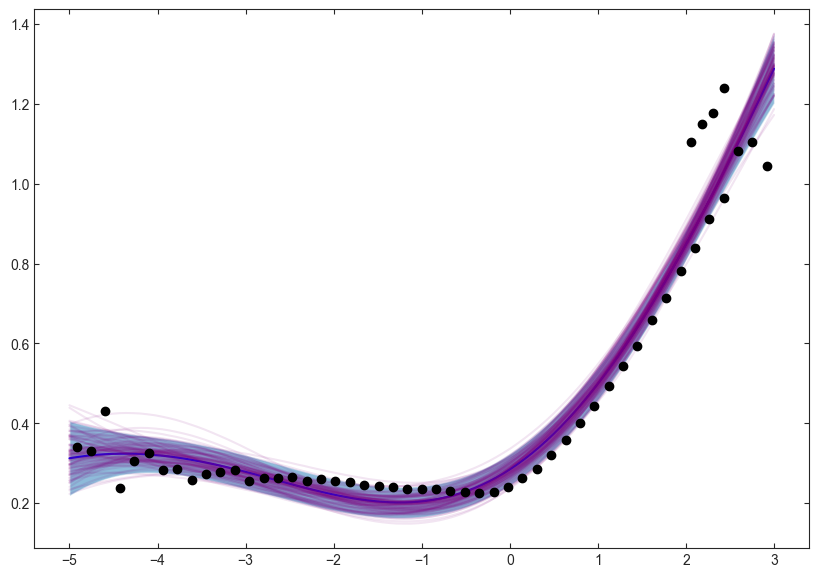

In [32]:
#train_sfrs, train_dust2, train_dust2_errs = torch.from_numpy(x), torch.from_numpy(y), torch.from_numpy(yerr)
test_sfrs = torch.linspace(-5, 3, 100)
trained_model, trained_likelihood = gpdp.train_gp_model_noerr(train_sfrs, train_dust2, [5.0, 15.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds_mu = gpdp.gp_evaluate_model(trained_model, test_sfrs)
gpdp.gp_plot_confidence_obs(f_preds_mu, test_sfrs, train_sfrs, train_dust2, train_dust2_errs*0, labelx="", labely="", alpha=0.5)

for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')


with torch.no_grad():
    for i in range(100):
        plt.plot(test_sfrs, f_preds_mu.sample().numpy(), c='purple', alpha=0.1)

In [8]:
#mean = np.interp(test_sfrs, train_sfrs, train_dust2)
#with torch.no_grad():
#    for i in range(500):
#        plt.plot(test_sfrs, f_preds_mu.sample().numpy()+mean, c='purple', alpha=0.1)
#    plt.plot(test_sfrs, mean, c='b')
#    lower, upper = f_preds_mu.confidence_region()
#    plt.fill_between(test_sfrs, lower+mean, upper+mean, alpha=0.2)

In [9]:
#test_sfrs = torch.linspace(-4, 3, 100)
#trained_model_sig, trained_likelihood_sig = gpdp.train_gp_model(torch.from_numpy(bin_centers_de), torch.from_numpy(avg_err), torch.from_numpy(avg_err*0), [2.0, 10.0], [-100, 100], lr=0.1, training_iter=10000)
#f_preds_sig = gpdp.gp_evaluate_model(trained_model_sig, test_sfrs)
#gpdp.gp_plot_confidence_obs(f_preds_sig, test_sfrs, torch.from_numpy(bin_centers_de), torch.from_numpy(avg_err), torch.from_numpy(avg_err*0), labelx="", labely="", alpha=0.5)

#for param_name, param in trained_model_sig.named_parameters():
#    print(f'Parameter name: {param_name:42} value = {param.item()}')

#with torch.no_grad():
#    for i in range(500):
#        plt.plot(test_sfrs, f_preds_sig.sample().numpy(), c='purple', alpha=0.1)

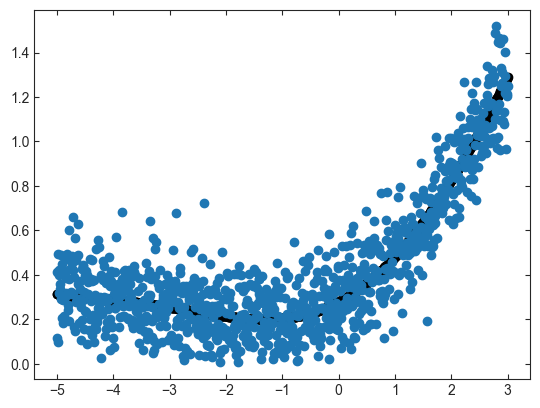

In [41]:
test_sfrs = torch.from_numpy(np.linspace(-5, 3, 1000))
#mean = np.interp(test_sfrs, train_sfrs, train_dust2)
f_preds_mu = gpdp.gp_evaluate_model(trained_model, test_sfrs)
#f_preds_sig = gpdp.gp_evaluate_model(trained_model_sig, test_sfrs)
mean_dust2 = f_preds_mu.sample().numpy()#+mean
#mean_dust2 = np.where(test_sfrs<-1, np.interp(-1, test_sfrs, mean_dust2), mean_dust2)
#sig_dust2 = f_preds_sig.sample().numpy()
#sig_dust2 = np.where(sig_dust2>0.4, 0.4, sig_dust2)
#sig_dust2 = np.where(test_sfrs<-1, 0.2, sig_dust2)
scatter = np.random.uniform(0.1, 0.3)
plt.scatter(test_sfrs, mean_dust2, c='k')
plt.scatter(test_sfrs, dp.truncated_normal(mean_dust2, scatter, 0.0, 4.0, len(test_sfrs)))

In [43]:
torch.save(trained_model.state_dict(), 'gp_models/dust2.pth')

<ErrorbarContainer object of 3 artists>

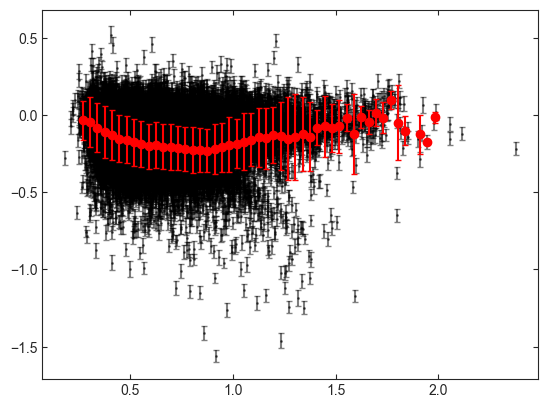

In [12]:
bin_centers_de, bin_means_de, bin_std_de = gpdp.process_samples(tau, n, 0.25, 2.0, 50)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)
plt.errorbar(tau, n, ne, fmt='ko', ms=1, capsize=2, alpha=0.5, zorder=-1)

<ErrorbarContainer object of 3 artists>

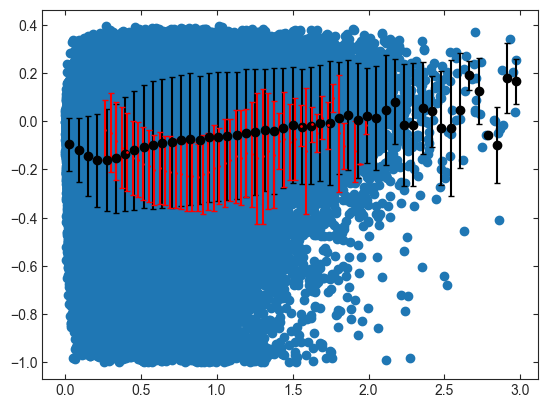

In [13]:
plt.scatter(dust2, dust_index)

bin_centers, bin_means, bin_std = gpdp.process_samples(dust2, dust_index, 0.0, 3.0, 50)

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)

In [14]:
train_dust2, train_dust_index, train_dust_index_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)
#avg_err = (bin_std + bin_std_de)/2
#x, y, yerr = gpdp.process_samples(train_sfrs, train_dust_index, 0.0, 3.0, 50)
#plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2, alpha=0.25)
#plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2, alpha=0.25)
#plt.errorbar(x, y, yerr, fmt='bo', capsize=2)

88.91810761680053
82.11007168792665
75.2615467251528
68.41659669687172
61.623396115691094
54.93378588734114
48.402633652720276
42.086977429806105
36.04493461935223
30.33436349027745
25.011271523762623
20.127975752159152
15.731036563927569
11.859010865277241
8.540105424866931
5.789858131638435
3.6090325362145457
1.9819729697955746
0.875719389330309
0.2401995989099174
0.0097728132395907
-0.03760197360251802
-0.08498162043186272
-0.13237007791039254
-0.1797160212313568
-0.2269645921915704
-0.27405740291269237
-0.32093246720753826
-0.3675240770297089
-0.4137626396625396
-0.45957449063904665
-0.5048816975066469
-0.5496018702569146
-0.5936479953950969
-0.636928312128404
-0.679346250942399
-0.7208004568922614
-0.7611849223095002
-0.8003892564561222
-0.8382991231905582
-0.8747968822530139
-0.9097624755932112
-0.943074607230172
-0.9746122728001279
-1.0042567015264847
-1.0318937757949833
-1.0574169874336632
-1.0807309698926693
-1.1017556066527066
-1.1204306548016378
-1.1367207383423494
-1.150620

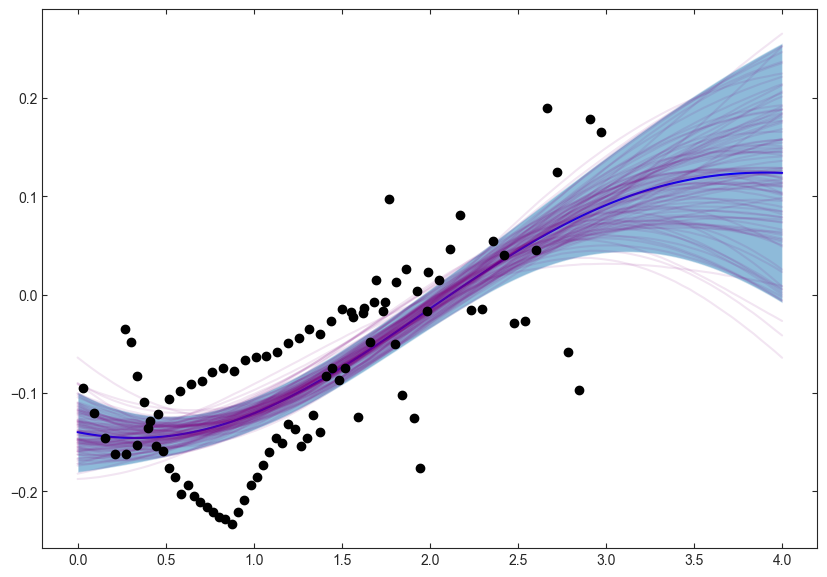

In [15]:
#train_dust2, train_dust_index, train_dust_index_errs = torch.from_numpy(bin_centers), torch.from_numpy(bin_means), torch.from_numpy(bin_std)

test_dust2 = torch.linspace(0, 4, 100)
#train_dust2, train_dust_index, train_dust_index_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, x, y, yerr)

trained_model, trained_likelihood = gpdp.train_gp_model_noerr(train_dust2, train_dust_index, [2.0, 10.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds = gpdp.gp_evaluate_model(trained_model, test_dust2)
gpdp.gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust_index, train_dust_index_errs*0, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

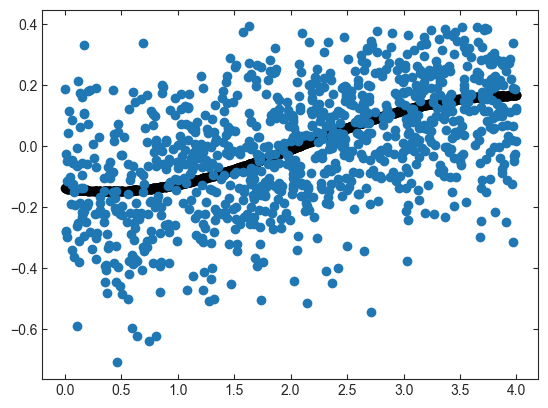

In [16]:
test_tau = torch.from_numpy(np.random.uniform(0, 4, 1000))
f_preds = gpdp.gp_evaluate_model(trained_model, test_tau)
mean_dust_index = f_preds.sample().numpy()
scatter = np.random.uniform(0.1, 0.4)
plt.scatter(test_tau, mean_dust_index, c='k')
plt.scatter(test_tau, dp.truncated_normal(mean_dust_index, scatter, -2.2, 0.4, len(test_tau)))

In [17]:
torch.save(trained_model.state_dict(), 'gp_models/dust_index.pth')

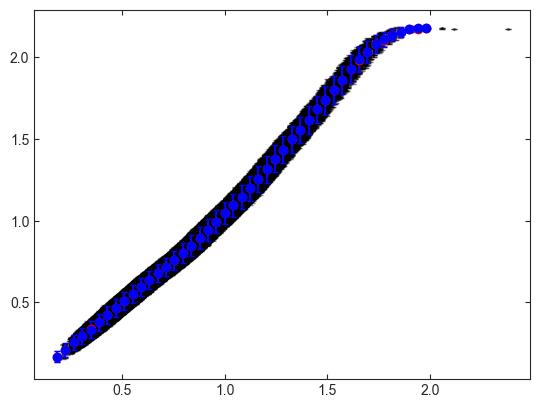

In [27]:
plt.errorbar(tau, tau1, tau1e, fmt='ko', ms=1, capsize=2, alpha=0.5)
bin_centers_de, bin_means_de, bin_std_de = gpdp.process_samples(tau, tau1, 0.0, 2.0, 50)
x, y, yerr = gpdp.process_samples_modified(tau, tau1, tau1e, 0.0, 2.0, 50)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)
plt.errorbar(x, y, yerr, fmt='bo', capsize=2)

bin_centers_de, bin_means_de, bin_std_de = x, y, yerr


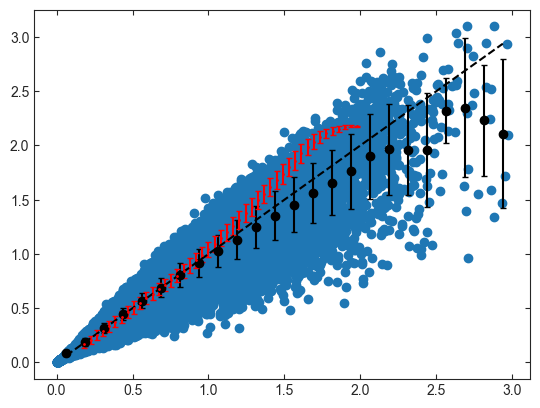

In [28]:
plt.scatter(dust2, dust1)

bin_centers, bin_means, bin_std = gpdp.process_samples(dust2, dust1, 0.0, 3.0, 25)

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)
plt.plot(bin_centers, bin_centers, c='k', ls='--')

19828.32103443937
19723.161684948784
19613.0840228441
19498.08904032126
19378.199392318646
19253.460248413307
19123.93984102283
18989.729504688203
18850.94333275751
18707.717470070234
18560.209031003655
18408.594661153715
18253.06877985456
18093.84155329111
17931.13665674541
17765.188889853234
17596.24171064725
17424.544752803868
17250.351386277234
17073.916374943397
16895.493676632243
16715.334421665375
16533.68509638735
16350.78594874277
16166.869624168865
15982.160032282241
15796.871438248645
15611.207767437827
15425.36210798516
15239.516393140453
15053.841243665822
14868.495949903412
14683.628573317032
14499.376148169818
14315.864965390649
14133.210922474793
13951.519925320334
13770.888330068015
13591.403415093502
13413.14387506663
13236.180330201238
13060.575844296462
12886.386444919777
12713.661638369518
12542.444911403158
12372.774211738684
12204.682400457737
12038.197671664544
11873.34393763542
11710.141180522482
11548.605773811956
11388.750777841278
11230.58621377293
11074.119

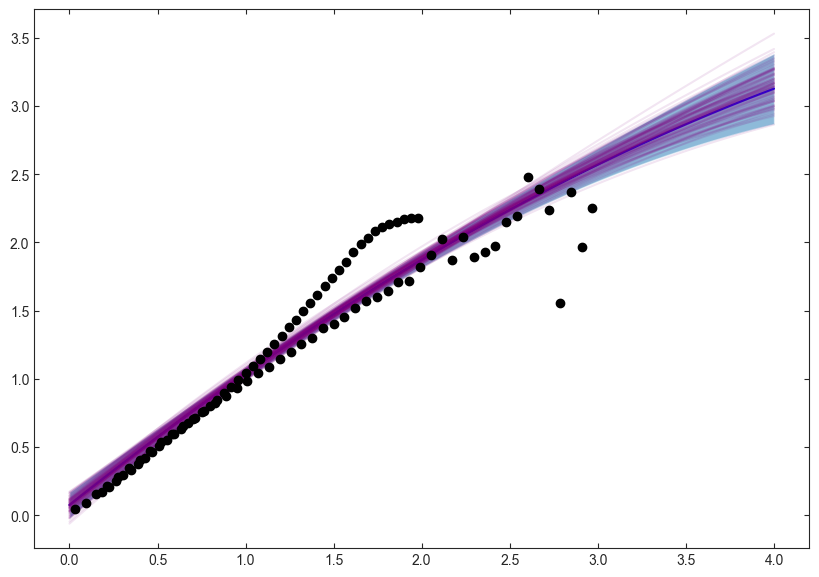

In [20]:
test_dust2 = torch.linspace(0, 4, 100)
train_dust2, train_dust1, train_dust1_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)

trained_model, trained_likelihood = gpdp.train_gp_model_noerr(train_dust2, train_dust1, [20.0, 100.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds = gpdp.gp_evaluate_model(trained_model, test_dust2)
gpdp.gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust1, train_dust1_errs*0, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

91.73769573307221
84.71400790483581
77.64861509271215
70.58699378681672
63.578862060662935
56.677721340659446
49.94019680706399
43.42515448295848
37.19257622805137
31.302179059651937
25.811772856430657
20.77536177300074
16.24101166080268
12.24853100775035
8.827048914991098
5.992621972560307
3.746061338443528
2.0712352137878427
0.9341554207834134
0.2831758869097086
0.05058575585313998
0.007328898975291552
-0.03548542820226338
-0.07782521295829432
-0.11959954145901384
-0.1607131454093701
-0.20106696854460893
-0.2405586883520414
-0.2790831684380925
-0.3165328104264306
-0.35279778210365004
-0.38776612454000553
-0.42132378375804463
-0.4533546643609854
-0.48374085186693117
-0.5123631884960624
-0.5391024125346606
-0.5638410879480212
-0.5864665574972054
-0.6068751335463032
-0.6249776668936313
-0.6407064774833797
-0.6540233853285413
-0.6649282726024308
-0.6734672959719058
-0.6797396232922951
-0.683901457958271
-0.686166188058607
-0.6867997837985137
-0.686111064800698
-0.684437130109649
-0.68212

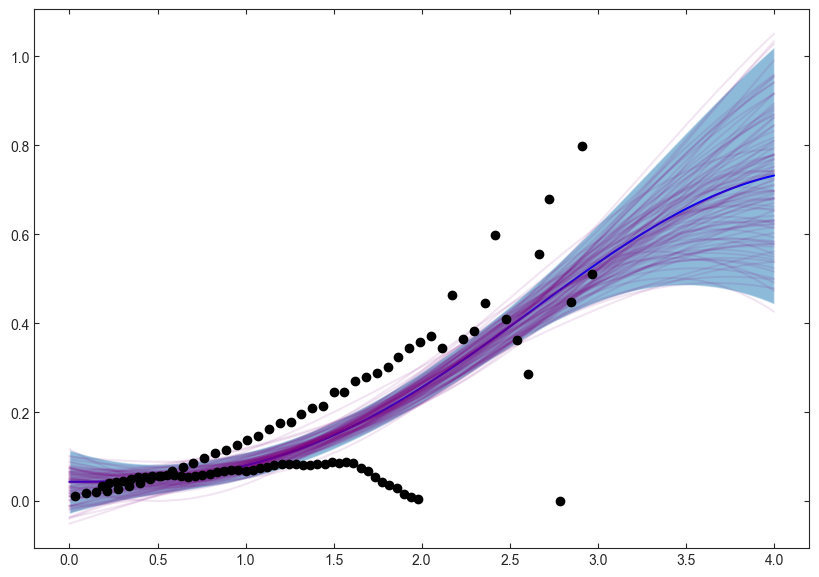

In [21]:
test_dust2 = torch.linspace(0, 4, 100)
train_dust2, train_dust1, train_dust1_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)

trained_model_sig, trained_likelihood_sig = gpdp.train_gp_model_noerr(train_dust2, train_dust1_errs, [2.0, 10.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds = gpdp.gp_evaluate_model(trained_model_sig, test_dust2)
gpdp.gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust1_errs, train_dust1_errs*0, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

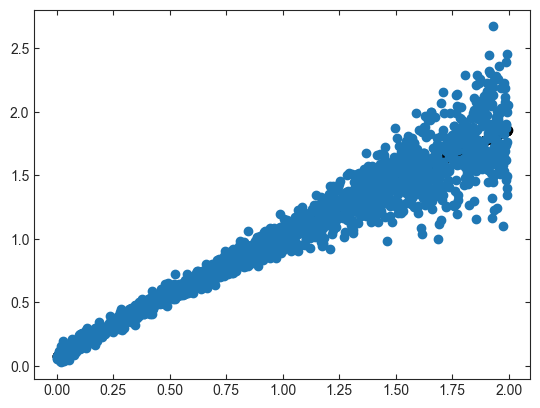

In [22]:
test_tau = torch.from_numpy(np.random.uniform(0, 2, 2000))
f_preds = gpdp.gp_evaluate_model(trained_model, test_tau)
f_preds_sig = gpdp.gp_evaluate_model(trained_model_sig, test_tau)
mean_dust1 = f_preds.sample().numpy()
sig_dust1 = f_preds_sig.sample().numpy()
sig_dust1 = np.where(sig_dust1<0.001, 0.001, sig_dust1)
#scatter = np.random.uniform(0.05, 0.4)
plt.scatter(test_tau, mean_dust1, c='k')
plt.scatter(test_tau, dp.truncated_normal(mean_dust1, sig_dust1, 0.0, 4.0, len(test_tau)))

In [23]:
torch.save(trained_model.state_dict(), 'gp_models/dust1.pth')
torch.save(trained_model_sig.state_dict(), 'gp_models/dust1sig.pth')